# MCTS Simulation v1

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Thư viện hiển thị thanh tiến trình (nếu không có, bạn có thể cài đặt hoặc loại bỏ)

def preprocess_data(df_close, df_volume):
    """
    Tiền xử lý dữ liệu: nội suy giá trị thiếu và tính lợi nhuận.
    
    Parameters:
    df_close (pd.DataFrame): DataFrame chứa giá đóng cửa
    df_volume (pd.DataFrame): DataFrame chứa khối lượng giao dịch
    
    Returns:
    pd.DataFrame: DataFrame chứa lợi nhuận hàng ngày
    """
    # Sao chép để không ảnh hưởng đến dữ liệu gốc
    df_close_processed = df_close.copy()
    
    # Đặt cột thời gian làm index
    df_close_processed.set_index('time', inplace=True)
    
    # Đảm bảo index là datetime
    df_close_processed.index = pd.to_datetime(df_close_processed.index)
    
    # Nội suy giá trị thiếu bằng phương pháp tuyến tính
    df_close_processed = df_close_processed.interpolate(method='linear', axis=0)
    
    # Tính lợi nhuận hàng ngày
    returns = df_close_processed.pct_change().dropna()
    
    return returns

def calculate_statistics(returns):
    """
    Tính toán các thông số thống kê cho Monte Carlo.
    
    Parameters:
    returns (pd.DataFrame): DataFrame chứa lợi nhuận hàng ngày
    
    Returns:
    tuple: (mean_returns, cov_matrix)
    """
    # Tính lợi nhuận kỳ vọng (trung bình hàng ngày)
    mean_returns = returns.mean()
    
    # Tính ma trận hiệp phương sai
    cov_matrix = returns.cov()
    
    return mean_returns, cov_matrix

def monte_carlo_simulation(mean_returns, cov_matrix, num_simulations=10000, time_horizon=252):
    """
    Thực hiện mô phỏng Monte Carlo cho nhiều danh mục đầu tư.
    
    Parameters:
    mean_returns (pd.Series): Lợi nhuận kỳ vọng
    cov_matrix (pd.DataFrame): Ma trận hiệp phương sai
    num_simulations (int): Số lượng mô phỏng (mặc định: 10000)
    time_horizon (int): Số ngày giao dịch trong năm (mặc định: 252)
    
    Returns:
    dict: Kết quả mô phỏng cho các danh mục
    """
    num_stocks = len(mean_returns)
    
    # Tạo một số danh mục đầu tư ngẫu nhiên để so sánh
    num_portfolios = 1000
    portfolio_results = []
    
    print("Tạo danh mục đầu tư ngẫu nhiên...")
    
    for _ in tqdm(range(num_portfolios)):
        # Tạo vector trọng số ngẫu nhiên
        weights = np.random.random(num_stocks)
        weights /= np.sum(weights)
        
        # Mô phỏng Monte Carlo cho danh mục này
        portfolio_returns = np.zeros(num_simulations)
        portfolio_risk = np.zeros(num_simulations)
        
        for sim in range(num_simulations):
            # Tạo lợi nhuận mô phỏng dựa trên phân phối đa biến chuẩn
            returns_sim = np.random.multivariate_normal(
                mean_returns * time_horizon, 
                cov_matrix * time_horizon, 
                1
            )
            
            # Tính lợi nhuận và rủi ro danh mục
            portfolio_returns[sim] = np.sum(returns_sim * weights)
            portfolio_risk[sim] = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * time_horizon, weights)))
        
        # Tính lợi nhuận và rủi ro trung bình
        mean_return = np.mean(portfolio_returns)
        mean_risk = np.mean(portfolio_risk)
        sharpe = mean_return / mean_risk  # Tỷ số Sharpe đơn giản (giả định lãi suất phi rủi ro = 0)
        
        portfolio_results.append({
            'weights': weights,
            'return': mean_return,
            'risk': mean_risk,
            'sharpe': sharpe
        })
    
    # Chuyển đổi kết quả thành DataFrame
    results_df = pd.DataFrame(portfolio_results)
    
    return results_df

def optimize_portfolio(mean_returns, cov_matrix, max_stocks=None, time_horizon=252):
    """
    Tối ưu hóa danh mục đầu tư để tối đa hóa tỷ số Sharpe với ràng buộc số lượng công ty tối đa.
    
    Parameters:
    mean_returns (pd.Series): Lợi nhuận kỳ vọng
    cov_matrix (pd.DataFrame): Ma trận hiệp phương sai
    max_stocks (int): Số lượng công ty tối đa để đầu tư (nếu None thì không có ràng buộc)
    time_horizon (int): Số ngày giao dịch trong năm (mặc định: 252)
    
    Returns:
    dict: Danh mục tối ưu
    """
    num_stocks = len(mean_returns)
    
    # Hàm mục tiêu: âm của tỷ số Sharpe (vì chúng ta muốn tối đa hóa Sharpe)
    def negative_sharpe(weights):
        portfolio_return = np.sum(mean_returns * weights) * time_horizon
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * time_horizon, weights)))
        return -portfolio_return / portfolio_risk
    
    # Ràng buộc: tổng trọng số = 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # Giới hạn: mỗi trọng số từ 0 đến 1
    bounds = tuple((0, 1) for _ in range(num_stocks))
    
    # Giá trị ban đầu: phân bổ đều
    initial_guess = np.array([1/num_stocks] * num_stocks)
    
    # Nếu có ràng buộc về số lượng công ty tối đa
    if max_stocks is not None and max_stocks < num_stocks:
        print(f"Tối ưu hóa với ràng buộc số lượng công ty tối đa: {max_stocks}")
        
        # Sử dụng thuật toán di truyền đơn giản để giải quyết bài toán ràng buộc
        best_sharpe = -float('inf')
        best_weights = None
        
        for _ in tqdm(range(1000)):  # Số lần lặp
            # Chọn ngẫu nhiên max_stocks công ty
            selected_stocks = np.zeros(num_stocks)
            selected_indices = np.random.choice(range(num_stocks), max_stocks, replace=False)
            selected_stocks[selected_indices] = 1
            
            # Tối ưu hóa với các công ty đã chọn
            sub_mean_returns = mean_returns * selected_stocks
            
            # Các công ty không được chọn sẽ có trọng số = 0
            sub_bounds = [(0, 1) if selected_stocks[i] > 0 else (0, 0) for i in range(num_stocks)]
            
            sub_result = minimize(negative_sharpe, initial_guess, method='SLSQP', 
                                bounds=sub_bounds, constraints=constraints)
            
            sharpe = -sub_result['fun']
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_weights = sub_result['x']
        
        result = {
            'weights': best_weights,
            'return': np.sum(mean_returns * best_weights) * time_horizon,
            'risk': np.sqrt(np.dot(best_weights.T, np.dot(cov_matrix * time_horizon, best_weights))),
            'sharpe': best_sharpe
        }
    else:
        print("Tối ưu hóa không giới hạn số lượng công ty")
        # Tối ưu hóa không giới hạn số lượng công ty
        optimization_result = minimize(negative_sharpe, initial_guess, method='SLSQP', 
                                   bounds=bounds, constraints=constraints)
        
        # Trích xuất kết quả
        weights = optimization_result['x']
        portfolio_return = np.sum(mean_returns * weights) * time_horizon
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * time_horizon, weights)))
        sharpe = portfolio_return / portfolio_risk
        
        result = {
            'weights': weights,
            'return': portfolio_return,
            'risk': portfolio_risk,
            'sharpe': sharpe
        }
    
    return result

def run_portfolio_optimization(df_close, df_volume, max_stocks=None, num_simulations=10000):
    """
    Thực hiện toàn bộ quy trình tối ưu hóa danh mục đầu tư:
    Tiền xử lý, tính thống kê, mô phỏng, tối ưu hóa.
    
    Parameters:
    df_close (pd.DataFrame): DataFrame chứa giá đóng cửa
    df_volume (pd.DataFrame): DataFrame chứa khối lượng giao dịch
    max_stocks (int): Số lượng công ty tối đa để đầu tư (nếu None thì không có ràng buộc)
    num_simulations (int): Số lượng mô phỏng Monte Carlo
    
    Returns:
    tuple: (optimal_weights, all_weights_df, visualizations)
    """
    print("1. Tiền xử lý dữ liệu...")
    returns = preprocess_data(df_close, df_volume)
    
    print("2. Tính toán thống kê...")
    mean_returns, cov_matrix = calculate_statistics(returns)
    
    print("3. Thực hiện mô phỏng Monte Carlo...")
    mc_results = monte_carlo_simulation(mean_returns, cov_matrix, num_simulations=num_simulations)
    
    print("4. Tối ưu hóa danh mục đầu tư...")
    optimal_portfolio = optimize_portfolio(mean_returns, cov_matrix, max_stocks=max_stocks)
    
    print("\nKết quả tối ưu:")
    print(f"Lợi nhuận kỳ vọng hàng năm: {optimal_portfolio['return']*100:.2f}%")
    print(f"Rủi ro hàng năm: {optimal_portfolio['risk']*100:.2f}%")
    print(f"Tỷ số Sharpe: {optimal_portfolio['sharpe']:.4f}")
    
    # Sắp xếp và lấy các công ty có trọng số > 0
    stock_symbols = returns.columns
    weights = optimal_portfolio['weights']
    
    # Tạo DataFrame cho việc hiển thị
    weights_df = pd.DataFrame({
        'Công ty': stock_symbols,
        'Trọng số': weights
    })
    weights_df = weights_df.sort_values('Trọng số', ascending=False)
    
    # Hiển thị các công ty được đầu tư (trọng số > 0.01 hoặc 1%)
    invested_stocks = weights_df[weights_df['Trọng số'] > 0.01]
    print("\nCác công ty được đầu tư (trọng số > 1%):")
    print(invested_stocks)
    
    # Hiển thị phân phối lợi nhuận và rủi ro từ Monte Carlo
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.scatter(mc_results['risk'], mc_results['return'], alpha=0.3, c=mc_results['sharpe'], cmap='viridis')
    plt.scatter(optimal_portfolio['risk'], optimal_portfolio['return'], s=100, c='r', marker='*')
    plt.colorbar(label='Sharpe ratio')
    plt.xlabel('Rủi ro hàng năm')
    plt.ylabel('Lợi nhuận kỳ vọng hàng năm')
    plt.title('Frontier hiệu quả từ mô phỏng Monte Carlo')
    
    plt.subplot(2, 2, 2)
    invested_stocks.plot(x='Công ty', y='Trọng số', kind='bar', ax=plt.gca())
    plt.title('Phân bổ danh mục đầu tư tối ưu')
    plt.ylabel('Trọng số')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 3)
    sns.heatmap(cov_matrix, cmap='coolwarm', annot=False)
    plt.title('Ma trận hiệp phương sai')
    
    plt.subplot(2, 2, 4)
    mean_returns.sort_values().plot(kind='bar')
    plt.title('Lợi nhuận kỳ vọng hàng ngày')
    plt.ylabel('Lợi nhuận kỳ vọng')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('portfolio_optimization_results.png')
    
    return optimal_portfolio['weights'], weights_df, mc_results


1. Tiền xử lý dữ liệu...
2. Tính toán thống kê...
3. Thực hiện mô phỏng Monte Carlo...
Tạo danh mục đầu tư ngẫu nhiên...


100%|██████████| 1000/1000 [1:11:20<00:00,  4.28s/it]


4. Tối ưu hóa danh mục đầu tư...
Tối ưu hóa với ràng buộc số lượng công ty tối đa: 3


100%|██████████| 1000/1000 [00:05<00:00, 184.35it/s]



Kết quả tối ưu:
Lợi nhuận kỳ vọng hàng năm: 47.57%
Rủi ro hàng năm: 14.66%
Tỷ số Sharpe: 3.2446

Các công ty được đầu tư (trọng số > 1%):
   Công ty  Trọng số
5      FPT  0.388070
10     LPB  0.369732
8      HDB  0.242199


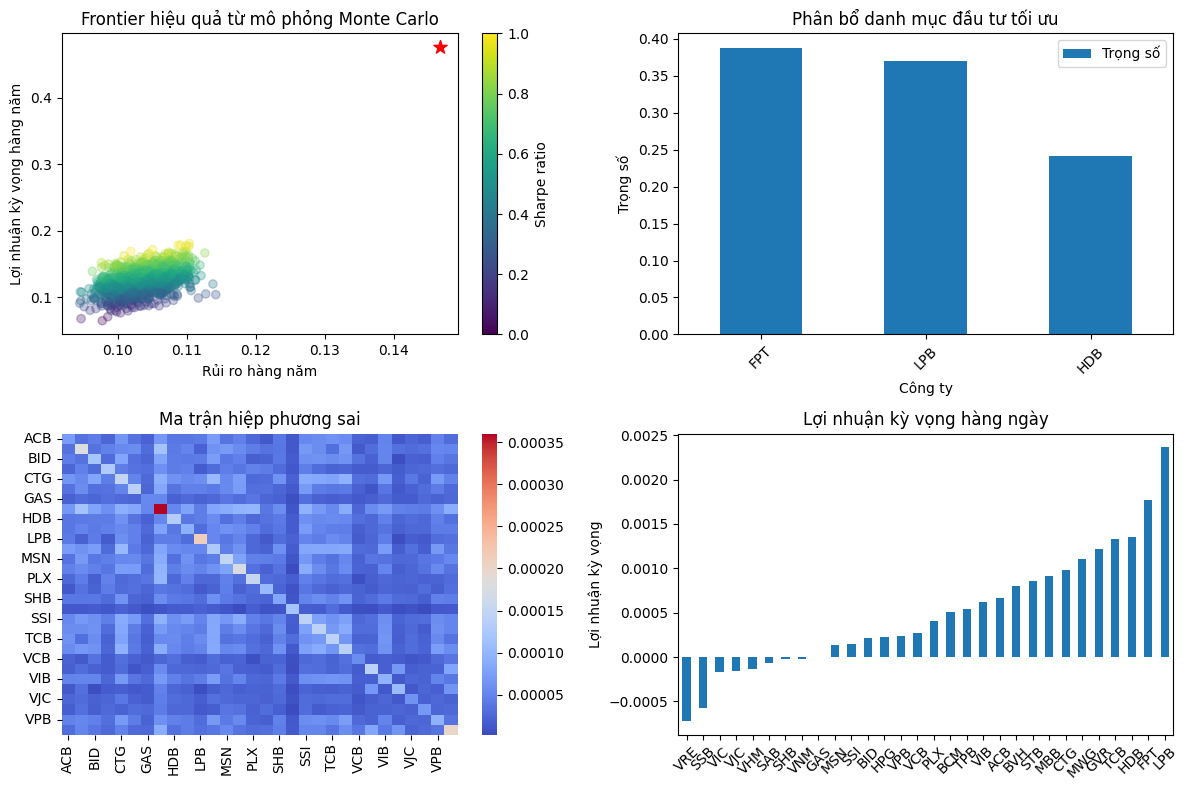

In [3]:
df_close = pd.read_csv('../data/2024/close.csv')
df_volume = pd.read_csv('../data/2024/volume.csv')

optimal_weights, weights_df, mc_results = run_portfolio_optimization(df_close, df_volume, max_stocks=3)

# MCTS Simulation v2

In [27]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

def preprocess_data(df_close, df_volume=None, years=1):
    """
    Tiền xử lý dữ liệu với xử lý nâng cao cho ngoại lệ và giá trị thiếu.
    
    Parameters:
    df_close (pd.DataFrame): DataFrame chứa giá đóng cửa
    df_volume (pd.DataFrame, optional): DataFrame chứa khối lượng giao dịch
    years (int): Số năm dữ liệu được sử dụng
    
    Returns:
    pd.DataFrame: DataFrame chứa lợi nhuận hàng ngày
    """
    # Sao chép để không ảnh hưởng đến dữ liệu gốc
    df_close_processed = df_close.copy()
    
    # Đặt cột thời gian làm index
    if 'time' in df_close_processed.columns:
        df_close_processed.set_index('time', inplace=True)
    
    # Đảm bảo index là datetime
    df_close_processed.index = pd.to_datetime(df_close_processed.index)
    
    # Lọc dữ liệu theo số năm
    if years < 5:
        start_date = f"20{24-years+1}-01-01"
        df_close_processed = df_close_processed[df_close_processed.index >= start_date]
    
    # Nội suy giá trị thiếu bằng phương pháp tuyến tính
    df_close_processed = df_close_processed.interpolate(method='linear', axis=0)
    
    # Tính lợi nhuận hàng ngày
    returns = df_close_processed.pct_change().dropna()
    
    # Xử lý ngoại lệ theo phương pháp Winsorization
    # Giới hạn ở phần trăm thứ 1 và 99 để loại bỏ ảnh hưởng của các biến động cực lớn
    for col in returns.columns:
        lower_bound = returns[col].quantile(0.01)
        upper_bound = returns[col].quantile(0.99)
        returns[col] = returns[col].clip(lower=lower_bound, upper=upper_bound)
    
    return returns

def shrink_covariance(sample_cov, shrinkage_factor=0.2):
    """
    Áp dụng kỹ thuật co ma trận hiệp phương sai để giảm ảnh hưởng của nhiễu.
    
    Parameters:
    sample_cov (pd.DataFrame): Ma trận hiệp phương sai mẫu
    shrinkage_factor (float): Hệ số co (0-1)
    
    Returns:
    pd.DataFrame: Ma trận hiệp phương sai sau khi co
    """
    # Tính ma trận đơn vị (target)
    n = len(sample_cov)
    diag_values = np.diag(sample_cov)
    target = np.diag(diag_values)
    
    # Thực hiện co theo công thức: shrunk_cov = (1-λ)*sample_cov + λ*target
    shrunk_cov = (1 - shrinkage_factor) * sample_cov.values + shrinkage_factor * target
    
    return pd.DataFrame(shrunk_cov, index=sample_cov.index, columns=sample_cov.columns)

def shrink_returns(sample_returns, market_return=None, shrinkage_factor=0.5):
    """
    Áp dụng kỹ thuật co lợi nhuận kỳ vọng để giảm ước lượng quá lớn.
    
    Parameters:
    sample_returns (pd.Series): Lợi nhuận kỳ vọng mẫu
    market_return (float): Lợi nhuận thị trường (nếu None, sẽ dùng trung bình)
    shrinkage_factor (float): Hệ số co (0-1)
    
    Returns:
    pd.Series: Lợi nhuận kỳ vọng sau khi co
    """
    # Nếu không có lợi nhuận thị trường, sử dụng trung bình của các cổ phiếu
    if market_return is None:
        market_return = sample_returns.mean()
        
    # Áp dụng công thức James-Stein: shrunk_return = (1-λ)*sample_return + λ*market_return
    shrunk_returns = (1 - shrinkage_factor) * sample_returns + shrinkage_factor * market_return
    
    return shrunk_returns

def calculate_statistics(returns, time_decay=False, half_life=252, 
                       use_shrinkage=True, return_shrinkage=0.5, cov_shrinkage=0.2):
    """
    Tính toán các thông số thống kê cho Monte Carlo với kỹ thuật co (shrinkage).
    
    Parameters:
    returns (pd.DataFrame): DataFrame chứa lợi nhuận hàng ngày
    time_decay (bool): Nếu True, dữ liệu gần đây được gán trọng số cao hơn
    half_life (int): Chu kỳ bán rã của trọng số (mặc định: 252 ngày = 1 năm)
    use_shrinkage (bool): Sử dụng kỹ thuật co để ổn định ước lượng
    return_shrinkage (float): Hệ số co cho lợi nhuận kỳ vọng (0-1)
    cov_shrinkage (float): Hệ số co cho ma trận hiệp phương sai (0-1)
    
    Returns:
    tuple: (mean_returns, cov_matrix)
    """
    if time_decay:
        # Tạo trọng số theo thời gian với mô hình hàm mũ giảm dần
        t = np.arange(len(returns))
        t = t[::-1]  # Đảo ngược để thời gian gần đây có trọng số cao hơn
        
        lambda_param = np.log(2) / half_life
        weights = np.exp(-lambda_param * t)
        weights = weights / sum(weights)  # Chuẩn hóa trọng số
        
        # Tính lợi nhuận kỳ vọng có trọng số
        weighted_returns = returns.multiply(weights[:, np.newaxis], axis=0)
        mean_returns = weighted_returns.sum(axis=0)
        
        # Tính ma trận hiệp phương sai có trọng số (xấp xỉ)
        # Đây là phương pháp đơn giản, nhưng đủ cho mục đích của chúng ta
        demeaned_returns = returns - mean_returns
        weighted_demeaned = demeaned_returns.multiply(np.sqrt(weights)[:, np.newaxis], axis=0)
        cov_matrix = weighted_demeaned.T.dot(weighted_demeaned)
    else:
        # Tính lợi nhuận kỳ vọng (trung bình hàng ngày)
        mean_returns = returns.mean()
        
        # Tính ma trận hiệp phương sai
        cov_matrix = returns.cov()
    
    # Áp dụng kỹ thuật co nếu được yêu cầu
    if use_shrinkage:
        # Co lợi nhuận kỳ vọng về giá trị trung bình
        mean_returns = shrink_returns(mean_returns, shrinkage_factor=return_shrinkage)
        
        # Co ma trận hiệp phương sai
        cov_matrix = shrink_covariance(cov_matrix, shrinkage_factor=cov_shrinkage)
    
    return mean_returns, cov_matrix

def generate_scenarios(mean_returns, cov_matrix, num_scenarios=100, time_horizon=252):
    """
    Tạo nhiều kịch bản khác nhau để đánh giá độ bền của danh mục.
    
    Parameters:
    mean_returns (pd.Series): Lợi nhuận kỳ vọng
    cov_matrix (pd.DataFrame): Ma trận hiệp phương sai
    num_scenarios (int): Số lượng kịch bản
    time_horizon (int): Số ngày giao dịch trong năm
    
    Returns:
    list: Danh sách các kịch bản (mean_returns, cov_matrix)
    """
    scenarios = []
    
    # 1. Kịch bản cơ sở
    scenarios.append((mean_returns, cov_matrix))
    
    # 2. Kịch bản thị trường tăng (lợi nhuận cao hơn 20%)
    bull_returns = mean_returns * 1.2
    scenarios.append((bull_returns, cov_matrix))
    
    # 3. Kịch bản thị trường giảm (lợi nhuận thấp hơn 20%)
    bear_returns = mean_returns * 0.8
    scenarios.append((bear_returns, cov_matrix))
    
    # 4. Kịch bản biến động cao (rủi ro tăng 50%)
    high_vol_cov = cov_matrix * 1.5
    scenarios.append((mean_returns, high_vol_cov))
    
    # 5. Kịch bản biến động thấp (rủi ro giảm 20%)
    low_vol_cov = cov_matrix * 0.8
    scenarios.append((mean_returns, low_vol_cov))
    
    # 6-100. Các kịch bản ngẫu nhiên từ phân phối bootstrap
    for _ in range(num_scenarios - 5):
        # Bootstrap lợi nhuận
        bootstrap_factor = np.random.normal(1, 0.1)  # Biến động 10% xung quanh giá trị trung bình
        sampled_returns = mean_returns * bootstrap_factor
        
        # Bootstrap rủi ro
        risk_factor = np.random.normal(1, 0.15)  # Biến động 15% xung quanh giá trị trung bình
        sampled_cov = cov_matrix * max(0.5, risk_factor)  # Đảm bảo không quá nhỏ
        
        scenarios.append((sampled_returns, sampled_cov))
    
    return scenarios

def optimize_robust_portfolio(mean_returns, cov_matrix, max_stocks=None, 
                            scenarios=None, risk_aversion=1.0,
                            max_weight=0.3, min_stocks=3, time_horizon=252):
    """
    Tối ưu hóa danh mục đầu tư mạnh mẽ với nhiều kịch bản khác nhau.
    
    Parameters:
    mean_returns (pd.Series): Lợi nhuận kỳ vọng
    cov_matrix (pd.DataFrame): Ma trận hiệp phương sai
    max_stocks (int): Số lượng công ty tối đa để đầu tư
    scenarios (list): Danh sách các kịch bản
    risk_aversion (float): Hệ số né rủi ro (gamma)
    max_weight (float): Trọng số tối đa cho một cổ phiếu
    min_stocks (int): Số lượng công ty tối thiểu
    time_horizon (int): Số ngày giao dịch trong năm
    
    Returns:
    dict: Danh mục tối ưu
    """
    num_stocks = len(mean_returns)
    
    # Nếu không có kịch bản, tạo một số kịch bản
    if scenarios is None:
        scenarios = generate_scenarios(mean_returns, cov_matrix, num_scenarios=20)
    
    # Hàm mục tiêu: hàm tiện ích trung bình trên tất cả các kịch bản
    def objective_function(weights):
        # Tính tiện ích trung bình
        utilities = []
        
        for scenario_returns, scenario_cov in scenarios:
            # Tính lợi nhuận kỳ vọng và rủi ro cho kịch bản này
            portfolio_return = np.sum(scenario_returns * weights) * time_horizon
            portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(scenario_cov * time_horizon, weights)))
            
            # Tính tiện ích: U = E[r] - 0.5 * gamma * sigma^2
            utility = portfolio_return - 0.5 * risk_aversion * portfolio_risk**2
            utilities.append(utility)
        
        # Trung bình của các tiện ích
        avg_utility = np.mean(utilities)
        
        # Thêm phạt cho danh mục quá tập trung
        concentration_penalty = -10 * np.sum(weights**2)
        
        # Đếm số lượng cổ phiếu có trọng số > 1%
        num_active_stocks = np.sum(weights > 0.01)
        
        # Phạt nếu số lượng cổ phiếu dưới ngưỡng tối thiểu
        diversity_penalty = 0
        if num_active_stocks < min_stocks:
            diversity_penalty = -5 * (min_stocks - num_active_stocks)
        
        return -(avg_utility + concentration_penalty + diversity_penalty)
    
    # Ràng buộc: tổng trọng số = 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # Giới hạn: mỗi trọng số từ 0 đến max_weight
    bounds = tuple((0, max_weight) for _ in range(num_stocks))
    
    # Nếu có ràng buộc về số lượng công ty tối đa
    if max_stocks is not None and max_stocks < num_stocks:
        print(f"Tối ưu hóa mạnh mẽ với ràng buộc số lượng công ty tối đa: {max_stocks}")
        
        # Tìm kiếm tổ hợp công ty tốt nhất
        best_utility = -float('inf')
        best_weights = None
        
        # Sử dụng nhiều cách chọn tổ hợp công ty
        strategies = [
            # 1. Cổ phiếu có lợi nhuận kỳ vọng cao
            (mean_returns.argsort()[::-1][:max_stocks*3], "lợi nhuận cao"),
            
            # 2. Cổ phiếu có rủi ro thấp
            (np.sqrt(np.diag(cov_matrix)).argsort()[:max_stocks*3], "rủi ro thấp"),
            
            # 3. Cổ phiếu có tỷ số Sharpe cao
            ((mean_returns / np.sqrt(np.diag(cov_matrix))).argsort()[::-1][:max_stocks*3], "Sharpe cao"),
            
            # 4. Các tổ hợp đa dạng
            (np.arange(num_stocks), "tổ hợp đa dạng")
        ]
        
        for candidate_indices, strategy_name in strategies:
            print(f"Thử nghiệm chiến lược: {strategy_name}")
            
            # Số lần thử cho mỗi chiến lược
            trials = 100 if len(candidate_indices) <= max_stocks else 200
            
            for _ in tqdm(range(trials)):
                # Chọn ngẫu nhiên max_stocks cổ phiếu từ nhóm ứng viên
                if len(candidate_indices) > max_stocks:
                    selected_indices = np.random.choice(candidate_indices, max_stocks, replace=False)
                else:
                    selected_indices = candidate_indices
                
                # Tạo mặt nạ cho các cổ phiếu được chọn
                selected_mask = np.zeros(num_stocks, dtype=bool)
                selected_mask[selected_indices] = True
                
                # Tạo giới hạn: các cổ phiếu không được chọn có trọng số = 0
                selected_bounds = [(0, max_weight) if selected_mask[i] else (0, 0) for i in range(num_stocks)]
                
                # Tạo điểm khởi đầu với phân bổ đều cho các cổ phiếu được chọn
                initial_weights = np.zeros(num_stocks)
                initial_weights[selected_indices] = 1/len(selected_indices)
                
                # Tối ưu hóa với cổ phiếu đã chọn
                try:
                    result = minimize(objective_function, initial_weights, method='SLSQP', 
                                   bounds=selected_bounds, constraints=constraints,
                                   options={'maxiter': 1000})
                    
                    if result['success']:
                        utility = -result['fun']
                        if utility > best_utility:
                            best_utility = utility
                            best_weights = result['x']
                except:
                    continue  # Bỏ qua nếu tối ưu hóa thất bại
        
        # Tính thống kê danh mục tối ưu
        portfolio_return = np.sum(mean_returns * best_weights) * time_horizon
        portfolio_risk = np.sqrt(np.dot(best_weights.T, np.dot(cov_matrix * time_horizon, best_weights)))
        sharpe = portfolio_return / portfolio_risk
        
        # Tính tiện ích
        utility = portfolio_return - 0.5 * risk_aversion * portfolio_risk**2
        
        result = {
            'weights': best_weights,
            'return': portfolio_return,
            'risk': portfolio_risk,
            'sharpe': sharpe,
            'utility': utility
        }
    else:
        print("Tối ưu hóa mạnh mẽ không giới hạn số lượng công ty")
        
        # Thử nhiều điểm khởi đầu khác nhau
        best_utility = -float('inf')
        best_weights = None
        
        for _ in range(10):  # Thử 10 điểm khởi đầu
            # Tạo điểm khởi đầu ngẫu nhiên có phân bổ đa dạng
            initial_weights = np.random.dirichlet(np.ones(num_stocks) * 0.5)
            
            # Tối ưu hóa
            result = minimize(objective_function, initial_weights, method='SLSQP', 
                           bounds=bounds, constraints=constraints,
                           options={'maxiter': 1000})
            
            if result['success']:
                utility = -result['fun']
                if utility > best_utility:
                    best_utility = utility
                    best_weights = result['x']
        
        # Tính thống kê danh mục tối ưu
        portfolio_return = np.sum(mean_returns * best_weights) * time_horizon
        portfolio_risk = np.sqrt(np.dot(best_weights.T, np.dot(cov_matrix * time_horizon, best_weights)))
        sharpe = portfolio_return / portfolio_risk
        
        # Tính tiện ích
        utility = portfolio_return - 0.5 * risk_aversion * portfolio_risk**2
        
        result = {
            'weights': best_weights,
            'return': portfolio_return,
            'risk': portfolio_risk,
            'sharpe': sharpe,
            'utility': utility
        }
    
    return result

def run_robust_optimization(df_close, df_volume=None, max_stocks=None, 
                          years=5, time_decay=True, half_life=252,
                          use_shrinkage=True, return_shrinkage=0.5, cov_shrinkage=0.2,
                          max_weight=0.3, min_stocks=3, risk_aversion=1.0,
                          random_state=42):
    """
    Thực hiện toàn bộ quy trình tối ưu hóa danh mục đầu tư mạnh mẽ.
    
    Parameters:
    df_close (pd.DataFrame): DataFrame chứa giá đóng cửa
    df_volume (pd.DataFrame, optional): DataFrame chứa khối lượng giao dịch
    max_stocks (int): Số lượng công ty tối đa để đầu tư
    years (int): Số năm dữ liệu sử dụng (mặc định: 5)
    time_decay (bool): Nếu True, dữ liệu gần đây được gán trọng số cao hơn (mặc định: True)
    half_life (int): Chu kỳ bán rã của trọng số thời gian (mặc định: 252 ngày = 1 năm)
    use_shrinkage (bool): Sử dụng kỹ thuật co để ổn định ước lượng
    return_shrinkage (float): Hệ số co cho lợi nhuận kỳ vọng (0-1)
    cov_shrinkage (float): Hệ số co cho ma trận hiệp phương sai (0-1)
    max_weight (float): Trọng số tối đa cho một cổ phiếu
    min_stocks (int): Số lượng công ty tối thiểu
    risk_aversion (float): Hệ số né rủi ro (gamma)
    random_state (int): Hạt ngẫu nhiên cho khả năng tái tạo
    
    Returns:
    tuple: (optimal_weights, weights_df, performance)
    """
    if random_state is not None:
        np.random.seed(random_state)
        
    total_start_time = time.time()
    
    print("1. Tiền xử lý dữ liệu...")
    returns = preprocess_data(df_close, df_volume, years=years)
    
    print("2. Tính toán thống kê với kỹ thuật co...")
    mean_returns, cov_matrix = calculate_statistics(
        returns, time_decay=time_decay, half_life=half_life,
        use_shrinkage=use_shrinkage, return_shrinkage=return_shrinkage, 
        cov_shrinkage=cov_shrinkage
    )
    
    print("3. Tạo các kịch bản đa dạng...")
    scenarios = generate_scenarios(mean_returns, cov_matrix, num_scenarios=30)
    
    print("4. Tối ưu hóa danh mục đầu tư mạnh mẽ...")
    optimal_portfolio = optimize_robust_portfolio(
        mean_returns, cov_matrix, max_stocks=max_stocks,
        scenarios=scenarios, risk_aversion=risk_aversion,
        max_weight=max_weight, min_stocks=min_stocks
    )
    
    print("\nKết quả tối ưu mạnh mẽ:")
    print(f"Lợi nhuận kỳ vọng hàng năm: {optimal_portfolio['return']*100:.2f}%")
    print(f"Rủi ro hàng năm: {optimal_portfolio['risk']*100:.2f}%")
    print(f"Tỷ số Sharpe: {optimal_portfolio['sharpe']:.4f}")
    print(f"Tiện ích: {optimal_portfolio['utility']:.4f}")
    
    # Sắp xếp và lấy các công ty có trọng số > 0
    stock_symbols = returns.columns
    weights = optimal_portfolio['weights']
    
    # Tạo DataFrame cho việc hiển thị
    weights_df = pd.DataFrame({
        'Công ty': stock_symbols,
        'Trọng số': weights
    })
    weights_df = weights_df.sort_values('Trọng số', ascending=False)
    
    # Hiển thị các công ty được đầu tư (trọng số > 1%)
    invested_stocks = weights_df[weights_df['Trọng số'] > 0.01]
    print("\nCác công ty được đầu tư (trọng số > 1%):")
    print(invested_stocks)
    
    # Kiểm tra các chỉ số đa dạng hóa
    num_active_stocks = np.sum(weights > 0.01)
    max_allocation = np.max(weights)
    herfindahl_index = np.sum(weights**2)  # Chỉ số tập trung Herfindahl
    
    print("\nChỉ số đa dạng hóa:")
    print(f"Số lượng cổ phiếu hoạt động (>1%): {num_active_stocks}")
    print(f"Phân bổ lớn nhất: {max_allocation*100:.2f}%")
    print(f"Chỉ số tập trung Herfindahl: {herfindahl_index:.4f} (càng thấp càng đa dạng)")
    
    # Hiển thị phân phối trọng số
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.pie(weights_df['Trọng số'].values[:10], 
          labels=weights_df['Công ty'].values[:10], 
          autopct='%1.1f%%',
          startangle=90)
    plt.title('Top 10 cổ phiếu trong danh mục')
    
    plt.subplot(2, 2, 2)
    invested_stocks.plot(x='Công ty', y='Trọng số', kind='bar', ax=plt.gca())
    plt.title('Phân bổ danh mục đầu tư tối ưu')
    plt.ylabel('Trọng số')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 3)
    sns.heatmap(cov_matrix, cmap='coolwarm', annot=False)
    plt.title('Ma trận hiệp phương sai')
    
    plt.subplot(2, 2, 4)
    returns.mean().sort_values().plot(kind='bar')
    plt.title('Lợi nhuận kỳ vọng hàng ngày')
    plt.ylabel('Lợi nhuận kỳ vọng')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('robust_portfolio_optimization.png')
    
    print(f"\nTổng thời gian chạy: {time.time() - total_start_time:.2f} giây")
    
    return optimal_portfolio['weights'], weights_df, optimal_portfolio

def evaluate_portfolio(weights, df_test, start_date, end_date, benchmark_weights=None):
    """
    Đánh giá hiệu suất của danh mục trên dữ liệu thử nghiệm và so sánh với benchmark.
    
    Parameters:
    weights (np.array): Trọng số danh mục
    df_test (pd.DataFrame): DataFrame chứa giá đóng cửa để kiểm tra
    start_date (str): Ngày bắt đầu đánh giá (YYYY-MM-DD)
    end_date (str): Ngày kết thúc đánh giá (YYYY-MM-DD)
    benchmark_weights (np.array, optional): Trọng số của danh mục benchmark để so sánh
    
    Returns:
    dict: Kết quả đánh giá
    """
    # Đảm bảo định dạng dữ liệu đúng
    df_eval = df_test.copy()
    if 'time' in df_eval.columns:
        df_eval.set_index('time', inplace=True)
    
    # Chuyển đổi index thành datetime
    df_eval.index = pd.to_datetime(df_eval.index)
    
    # Lọc theo khoảng thời gian đánh giá
    df_eval = df_eval[(df_eval.index >= start_date) & (df_eval.index <= end_date)]
    
    # Tính lợi nhuận cho dữ liệu kiểm tra
    returns_test = df_eval.pct_change().dropna()
    
    # Tính lợi nhuận danh mục hàng ngày
    portfolio_returns = returns_test.dot(weights)
    
    # Tính lợi nhuận tích lũy
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1
    
    # Nếu có benchmark
    if benchmark_weights is not None:
        benchmark_returns = returns_test.dot(benchmark_weights)
        benchmark_cumulative = (1 + benchmark_returns).cumprod() - 1
    else:
        # Sử dụng danh mục phân bổ đều làm benchmark
        equal_weights = np.ones(len(weights)) / len(weights)
        benchmark_returns = returns_test.dot(equal_weights)
        benchmark_cumulative = (1 + benchmark_returns).cumprod() - 1
    
    # Các chỉ số đánh giá
    total_return = cumulative_returns.iloc[-1]
    annualized_return = (1 + total_return) ** (252 / len(portfolio_returns)) - 1
    volatility = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
    
    # Tính max drawdown
    rolling_max = cumulative_returns.cummax()
    drawdowns = rolling_max - cumulative_returns
    max_drawdown = drawdowns.max()
    
    # Tính so với benchmark
    benchmark_return = benchmark_cumulative.iloc[-1]
    excess_return = total_return - benchmark_return
    
    # Tạo DataFrame hiệu suất hàng ngày
    performance_df = pd.DataFrame({
        'Portfolio Daily Return': portfolio_returns,
        'Portfolio Cumulative Return': cumulative_returns,
        'Benchmark Daily Return': benchmark_returns,
        'Benchmark Cumulative Return': benchmark_cumulative
    })
    
    # Vẽ biểu đồ hiệu suất
    plt.figure(figsize=(10, 6))
    performance_df[['Portfolio Cumulative Return', 'Benchmark Cumulative Return']].plot()
    plt.title('Hiệu suất danh mục và benchmark trong giai đoạn đánh giá')
    plt.xlabel('Ngày')
    plt.ylabel('Lợi nhuận tích lũy')
    plt.grid(True)
    plt.savefig('portfolio_performance_comparison.png')
    
    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'volatility': volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'performance_df': performance_df,
        'excess_return': excess_return
    }

def stress_test_portfolio(weights, df_close, stress_scenarios=None):
    """
    Thực hiện kiểm tra độ bền của danh mục trong các kịch bản thị trường khác nhau.
    
    Parameters:
    weights (np.array): Trọng số danh mục
    df_close (pd.DataFrame): DataFrame chứa giá đóng cửa
    stress_scenarios (dict, optional): Dictionary chứa các kịch bản kiểm tra độ bền
    
    Returns:
    pd.DataFrame: Kết quả kiểm tra độ bền
    """
    # Sao chép và xử lý df_close
    df = df_close.copy()
    if 'time' in df.columns:
        df.set_index('time', inplace=True)
    
    # Chuyển đổi index thành datetime
    df.index = pd.to_datetime(df.index)
    
    # Tính lợi nhuận hàng ngày
    returns = df.pct_change().dropna()
    
    # Nếu không có kịch bản kiểm tra độ bền, tạo một số kịch bản mặc định
    if stress_scenarios is None:
        stress_scenarios = {
            'Black Monday (1987)': {'duration': 5, 'market_return': -0.30},
            'Dot-com Bust (2000)': {'duration': 30, 'market_return': -0.20},
            'Financial Crisis (2008)': {'duration': 21, 'market_return': -0.40},
            'COVID-19 (2020)': {'duration': 23, 'market_return': -0.35},
            'Bear Market': {'duration': 90, 'market_return': -0.25},
            'Market Correction': {'duration': 30, 'market_return': -0.15},
            'Interest Rate Hike': {'duration': 30, 'market_return': -0.10, 'correlation_adjustment': 0.2},
            'Tech Sector Crash': {'duration': 21, 'market_return': -0.25, 'tech_stocks': True},
            'Banking Crisis': {'duration': 14, 'market_return': -0.18, 'banking_stocks': True},
            'Inflation Surge': {'duration': 60, 'market_return': -0.15, 'correlation_adjustment': 0.3}
        }
    
    # Tính ma trận hiệp phương sai của lợi nhuận
    cov_matrix = returns.cov()
    
    # Danh sách kết quả
    stress_results = []
    
    # Thực hiện kiểm tra độ bền cho từng kịch bản
    for scenario_name, scenario_params in stress_scenarios.items():
        # Lấy tham số kịch bản
        duration = scenario_params.get('duration', 21)  # Mặc định 21 ngày
        market_return = scenario_params.get('market_return', -0.20)  # Mặc định -20%
        corr_adjustment = scenario_params.get('correlation_adjustment', 0)  # Mặc định không điều chỉnh
        
        # Mô phỏng lợi nhuận hàng ngày trong kịch bản này
        daily_market_return = (1 + market_return) ** (1 / duration) - 1
        
        # Tính lợi nhuận cho từng cổ phiếu dựa trên beta và điều chỉnh tương quan
        betas = calculate_betas(returns)
        scenario_returns = []
        
        for day in range(duration):
            # Tạo vector lợi nhuận cho ngày này
            if corr_adjustment > 0:
                # Tăng tương quan trong khủng hoảng
                adjusted_cov = adjust_correlation(cov_matrix, corr_adjustment)
                day_returns = np.random.multivariate_normal(
                    betas * daily_market_return, 
                    adjusted_cov,
                    1
                )[0]
            else:
                # Sử dụng beta trực tiếp
                day_returns = betas * daily_market_return + np.random.normal(0, 0.01, len(betas))
            
            scenario_returns.append(day_returns)
        
        # Chuyển đổi thành DataFrame
        scenario_df = pd.DataFrame(scenario_returns, columns=returns.columns)
        
        # Tính lợi nhuận danh mục mỗi ngày
        portfolio_returns = scenario_df.dot(weights)
        
        # Tính lợi nhuận tích lũy
        cumulative_return = (1 + portfolio_returns).prod() - 1
        
        # Tính max drawdown
        cumulative_curve = (1 + portfolio_returns).cumprod() - 1
        rolling_max = cumulative_curve.cummax()
        drawdowns = rolling_max - cumulative_curve
        max_drawdown = drawdowns.max()
        
        # Thêm vào kết quả
        stress_results.append({
            'Scenario': scenario_name,
            'Duration (days)': duration,
            'Market Return': market_return,
            'Portfolio Return': cumulative_return,
            'Max Drawdown': max_drawdown,
            'Daily VaR (95%)': np.percentile(portfolio_returns, 5)
        })
    
    # Chuyển đổi thành DataFrame
    results_df = pd.DataFrame(stress_results)
    
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    results_df.plot(x='Scenario', y='Portfolio Return', kind='bar', ax=plt.gca())
    plt.title('Lợi nhuận danh mục trong các kịch bản khủng hoảng')
    plt.xticks(rotation=45)
    plt.ylabel('Lợi nhuận')
    
    plt.subplot(1, 2, 2)
    results_df.plot(x='Scenario', y='Max Drawdown', kind='bar', ax=plt.gca())
    plt.title('Mức sụt giảm tối đa trong các kịch bản khủng hoảng')
    plt.xticks(rotation=45)
    plt.ylabel('Max Drawdown')
    
    plt.tight_layout()
    plt.savefig('portfolio_stress_test.png')
    
    return results_df

def calculate_betas(returns, market_index=None):
    """
    Tính beta của các cổ phiếu so với thị trường.
    
    Parameters:
    returns (pd.DataFrame): DataFrame chứa lợi nhuận hàng ngày
    market_index (pd.Series, optional): Lợi nhuận của chỉ số thị trường
    
    Returns:
    np.array: Beta của các cổ phiếu
    """
    # Nếu không có chỉ số thị trường, sử dụng trung bình của tất cả cổ phiếu
    if market_index is None:
        market_index = returns.mean(axis=1)
    
    # Tính beta cho từng cổ phiếu
    betas = []
    for col in returns.columns:
        # Loại bỏ các giá trị NaN
        mask = ~np.isnan(returns[col]) & ~np.isnan(market_index)
        stock_returns = returns[col][mask]
        market_returns = market_index[mask]
        
        # Tính beta bằng phương pháp hồi quy tuyến tính
        if len(stock_returns) > 0:
            cov = np.cov(stock_returns, market_returns)[0, 1]
            var = np.var(market_returns)
            beta = cov / var if var > 0 else 1.0
        else:
            beta = 1.0
        
        betas.append(beta)
    
    return np.array(betas)

def adjust_correlation(cov_matrix, adjustment_factor):
    """
    Điều chỉnh ma trận hiệp phương sai để tăng tương quan trong khủng hoảng.
    
    Parameters:
    cov_matrix (pd.DataFrame): Ma trận hiệp phương sai
    adjustment_factor (float): Hệ số điều chỉnh tương quan
    
    Returns:
    pd.DataFrame: Ma trận hiệp phương sai đã điều chỉnh
    """
    # Chuyển đổi sang ma trận tương quan
    std_devs = np.sqrt(np.diag(cov_matrix))
    corr_matrix = cov_matrix.copy()
    
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            corr_matrix.iloc[i, j] = cov_matrix.iloc[i, j] / (std_devs[i] * std_devs[j])
    
    # Điều chỉnh tương quan
    adjusted_corr = corr_matrix.copy()
    
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            if i != j:
                # Tăng tương quan (nếu dương) hoặc giảm tương quan âm (về 0)
                if corr_matrix.iloc[i, j] > 0:
                    adjusted_corr.iloc[i, j] = min(1, corr_matrix.iloc[i, j] + adjustment_factor)
                else:
                    adjusted_corr.iloc[i, j] = max(-1, corr_matrix.iloc[i, j] * (1 - adjustment_factor))
    
    # Chuyển lại thành ma trận hiệp phương sai
    adjusted_cov = adjusted_corr.copy()
    
    for i in range(len(adjusted_corr)):
        for j in range(len(adjusted_corr)):
            adjusted_cov.iloc[i, j] = adjusted_corr.iloc[i, j] * std_devs[i] * std_devs[j]
    
    return adjusted_cov

# Ví dụ sử dụng
"""
# Tối ưu hóa danh mục mạnh mẽ
optimal_weights, weights_df, optimal_portfolio = run_robust_optimization(
    df_close=df_close,
    df_volume=df_volume,
    max_stocks=8,  # Tăng số lượng công ty để có danh mục đa dạng hơn
    years=5,  # Sử dụng dữ liệu 5 năm
    time_decay=True,  # Vẫn sử dụng time decay nhưng với half-life dài hơn
    half_life=252,  # Tăng chu kỳ bán rã lên 1 năm thay vì 6 tháng
    use_shrinkage=True,  # Sử dụng kỹ thuật co để ổn định ước lượng
    return_shrinkage=0.5,  # Co lợi nhuận kỳ vọng 50% về giá trị trung bình
    cov_shrinkage=0.2,  # Co ma trận hiệp phương sai 20%
    max_weight=0.25,  # Giới hạn trọng số tối đa cho mỗi cổ phiếu là 25%
    min_stocks=5,  # Yêu cầu tối thiểu 5 cổ phiếu trong danh mục
    risk_aversion=1.5  # Tăng mức độ né rủi ro
)

# Đánh giá hiệu suất trên dữ liệu 2 tháng đầu năm 2025
performance = evaluate_portfolio(
    weights=optimal_weights,
    df_test=df_close,  # Giả sử df_close đã bao gồm dữ liệu 2025
    start_date='2025-01-01',
    end_date='2025-02-28'
)

print("\nKết quả đánh giá:")
print(f"Tổng lợi nhuận: {performance['total_return']*100:.2f}%")
print(f"Lợi nhuận hàng năm: {performance['annualized_return']*100:.2f}%")
print(f"Độ biến động: {performance['volatility']*100:.2f}%")
print(f"Tỷ số Sharpe: {performance['sharpe_ratio']:.4f}")
print(f"Drawdown tối đa: {performance['max_drawdown']*100:.2f}%")
print(f"Lợi nhuận vượt trội so với benchmark: {performance['excess_return']*100:.2f}%")

# Kiểm tra độ bền của danh mục
stress_results = stress_test_portfolio(
    weights=optimal_weights,
    df_close=df_close
)

print("\nKết quả kiểm tra độ bền:")
print(stress_results)
"""

'\n# Tối ưu hóa danh mục mạnh mẽ\noptimal_weights, weights_df, optimal_portfolio = run_robust_optimization(\n    df_close=df_close,\n    df_volume=df_volume,\n    max_stocks=8,  # Tăng số lượng công ty để có danh mục đa dạng hơn\n    years=5,  # Sử dụng dữ liệu 5 năm\n    time_decay=True,  # Vẫn sử dụng time decay nhưng với half-life dài hơn\n    half_life=252,  # Tăng chu kỳ bán rã lên 1 năm thay vì 6 tháng\n    use_shrinkage=True,  # Sử dụng kỹ thuật co để ổn định ước lượng\n    return_shrinkage=0.5,  # Co lợi nhuận kỳ vọng 50% về giá trị trung bình\n    cov_shrinkage=0.2,  # Co ma trận hiệp phương sai 20%\n    max_weight=0.25,  # Giới hạn trọng số tối đa cho mỗi cổ phiếu là 25%\n    min_stocks=5,  # Yêu cầu tối thiểu 5 cổ phiếu trong danh mục\n    risk_aversion=1.5  # Tăng mức độ né rủi ro\n)\n\n# Đánh giá hiệu suất trên dữ liệu 2 tháng đầu năm 2025\nperformance = evaluate_portfolio(\n    weights=optimal_weights,\n    df_test=df_close,  # Giả sử df_close đã bao gồm dữ liệu 2025\n   

1. Tiền xử lý dữ liệu...
2. Tính toán thống kê với kỹ thuật co...
3. Tạo các kịch bản đa dạng...
4. Tối ưu hóa danh mục đầu tư mạnh mẽ...
Tối ưu hóa mạnh mẽ với ràng buộc số lượng công ty tối đa: 8
Thử nghiệm chiến lược: lợi nhuận cao


100%|██████████| 200/200 [00:21<00:00,  9.18it/s]


Thử nghiệm chiến lược: rủi ro thấp


100%|██████████| 200/200 [00:18<00:00, 10.93it/s]


Thử nghiệm chiến lược: Sharpe cao


100%|██████████| 200/200 [00:21<00:00,  9.34it/s]


Thử nghiệm chiến lược: tổ hợp đa dạng


100%|██████████| 200/200 [00:22<00:00,  8.86it/s]



Kết quả tối ưu mạnh mẽ:
Lợi nhuận kỳ vọng hàng năm: 15.54%
Rủi ro hàng năm: 13.47%
Tỷ số Sharpe: 1.1541
Tiện ích: 0.1418

Các công ty được đầu tư (trọng số > 1%):
   Công ty  Trọng số
10     LPB  0.130487
5      FPT  0.128272
8      HDB  0.126587
19     STB  0.124145
20     TCB  0.123543
11     MBB  0.123163
4      CTG  0.123114
28     VPB  0.120690

Chỉ số đa dạng hóa:
Số lượng cổ phiếu hoạt động (>1%): 8
Phân bổ lớn nhất: 13.05%
Chỉ số tập trung Herfindahl: 0.1251 (càng thấp càng đa dạng)

Tổng thời gian chạy: 84.72 giây

Kết quả đánh giá:
Tổng lợi nhuận: 3.02%
Lợi nhuận hàng năm: 14.07%
Độ biến động: 11.96%
Tỷ số Sharpe: 1.1763
Drawdown tối đa: 3.22%


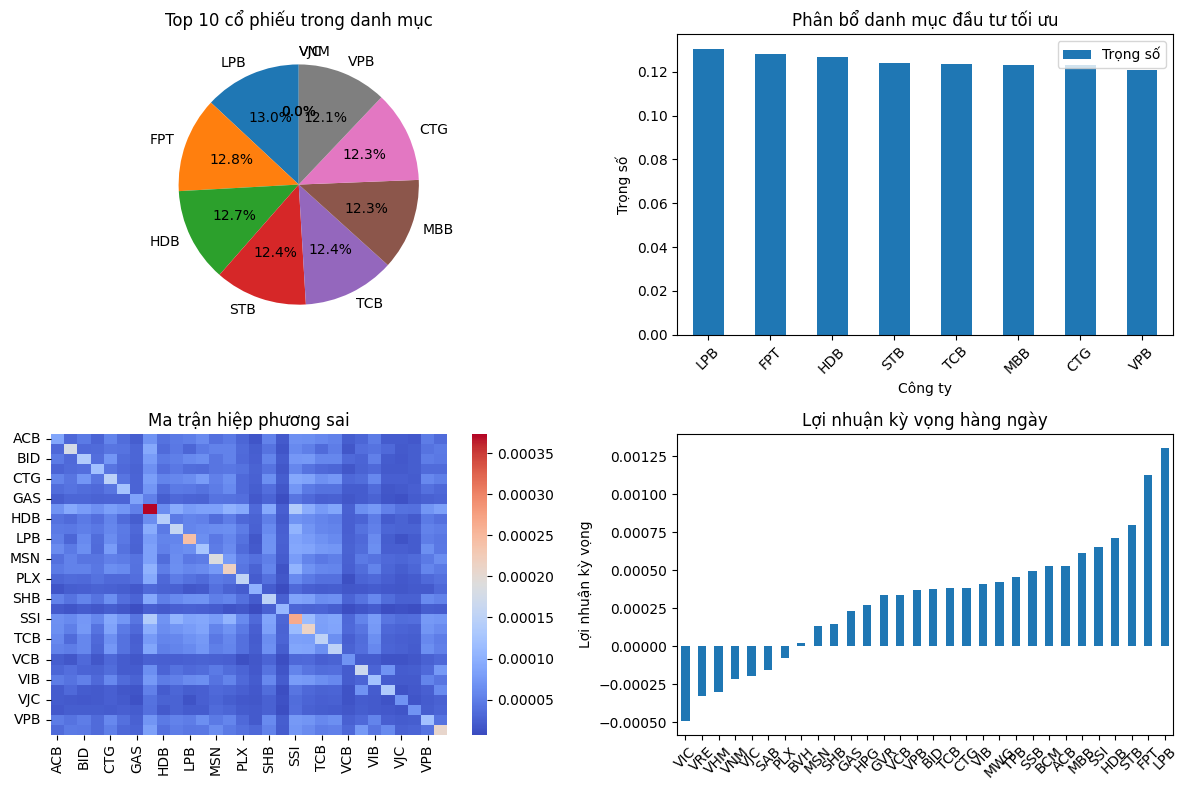

<Figure size 1000x600 with 0 Axes>

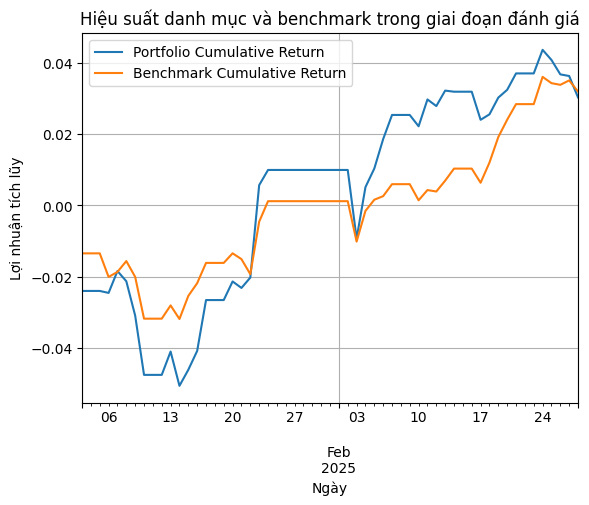

In [28]:
import warnings
warnings.filterwarnings('ignore')

df_close = pd.read_csv('../data/vn30/close.csv')
df_volume = pd.read_csv('../data/vn30/volume.csv')
df_test = pd.read_csv('../data/2025/close.csv')

# Sử dụng dữ liệu 5 năm và giới hạn 3 công ty
# Tối ưu hóa danh mục mạnh mẽ
optimal_weights, weights_df, optimal_portfolio = run_robust_optimization(
    df_close=df_close,
    df_volume=df_volume,
    max_stocks=8,                # Tăng số lượng công ty cho đa dạng hóa
    years=5,                     # Sử dụng dữ liệu 5 năm
    time_decay=True,             # Vẫn sử dụng time decay nhưng dài hạn hơn
    half_life=252,               # Tăng chu kỳ bán rã lên 1 năm
    use_shrinkage=True,          # Sử dụng kỹ thuật co
    return_shrinkage=0.5,        # Co lợi nhuận kỳ vọng 50% về trung bình
    cov_shrinkage=0.2,           # Co ma trận hiệp phương sai 20%
    max_weight=0.25,             # Giới hạn mỗi cổ phiếu tối đa 25%
    min_stocks=5,                # Yêu cầu tối thiểu 5 cổ phiếu
    risk_aversion=1.5            # Tăng mức độ né rủi ro
)

# Đánh giá hiệu suất trên dữ liệu 2 tháng đầu năm 2025
performance = evaluate_portfolio(
    weights=optimal_weights,
    df_test=df_test,  # Giả sử df_close đã bao gồm dữ liệu 2025
    start_date='2025-01-01',
    end_date='2025-02-28'
)

print("\nKết quả đánh giá:")
print(f"Tổng lợi nhuận: {performance['total_return']*100:.2f}%")
print(f"Lợi nhuận hàng năm: {performance['annualized_return']*100:.2f}%")
print(f"Độ biến động: {performance['volatility']*100:.2f}%")
print(f"Tỷ số Sharpe: {performance['sharpe_ratio']:.4f}")
print(f"Drawdown tối đa: {performance['max_drawdown']*100:.2f}%")